# Load libraries

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Download dataset

In [2]:
!wget 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'

--2022-11-04 05:45:49--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   221MB/s    in 0.3s    

2022-11-04 05:45:49 (221 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]



In [3]:
!unzip cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

# File deletion

In [4]:
!rm cats_and_dogs.zip

In [5]:
!rm -rf __MACOSX

In [6]:
PATH = 'cats_and_dogs'

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')

# -1 because of DS_Store
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])-1
total_val   = sum([len(files) for r, d, files in os.walk(validation_dir)])-1
total_test  = len(os.listdir(test_dir))-1

print('Train:', total_train) 
print('Validation:', total_val)
print('Test:', total_test)

Train: 2000
Validation: 1000
Test: 50


# Load data

In [7]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [8]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator       = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

val_data_gen   = validation_image_generator.flow_from_directory(
                    validation_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

test_data_gen  = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    classes=['test'],
                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# Explore data

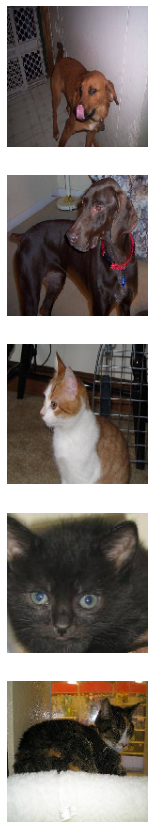

In [9]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

# Data augmentation

In [10]:
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            horizontal_flip=True,
                            rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            fill_mode="nearest")

Found 2000 images belonging to 2 classes.


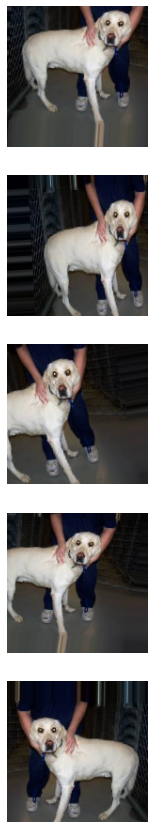

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

# Build model

In [12]:
model = Sequential()

# Convolutions
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
train_steps = int(ceil(1. * total_train / batch_size))
val_steps   = int(ceil(1. * total_val / batch_size))

print(train_steps, val_steps)

16 8


In [14]:
history = model.fit(
            train_data_gen, #steps_per_epoch=train_steps,
            validation_data=val_data_gen, #validation_steps=val_steps,
            epochs=epochs)

Epoch 1/15
16/16 [==============================] - 27s 1s/step - loss: 3.5371 - accuracy: 0.4960 - val_loss: 0.9019 - val_accuracy: 0.4990
Epoch 2/15
16/16 [==============================] - 16s 1s/step - loss: 0.8099 - accuracy: 0.5045 - val_loss: 0.6688 - val_accuracy: 0.5800
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 0.6762 - accuracy: 0.5685 - val_loss: 0.6532 - val_accuracy: 0.6040
Epoch 4/15
16/16 [==============================] - 16s 1s/step - loss: 0.6904 - accuracy: 0.5595 - val_loss: 0.6558 - val_accuracy: 0.5870
Epoch 5/15
16/16 [==============================] - 16s 1s/step - loss: 0.6637 - accuracy: 0.5940 - val_loss: 0.7280 - val_accuracy: 0.5110
Epoch 6/15
16/16 [==============================] - 16s 1s/step - loss: 0.6986 - accuracy: 0.5540 - val_loss: 0.6376 - val_accuracy: 0.6430
Epoch 7/15
16/16 [==============================] - 19s 1s/step - loss: 0.6586 - accuracy: 0.6115 - val_loss: 0.6832 - val_accuracy: 0.5550
Epoch 8/15
16/16 [==

# Evaluate

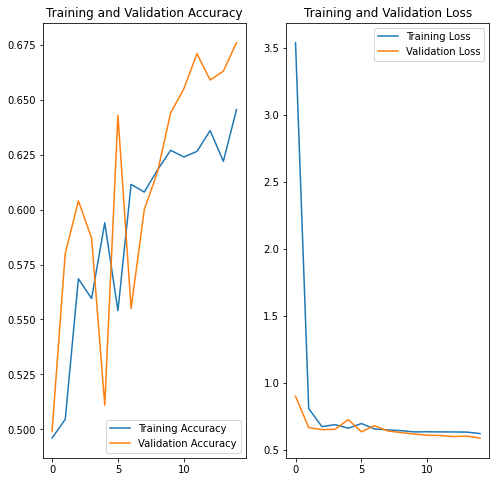

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

1/1 [==============================] - 1s 537ms/step


array([0.51857686, 0.15713756, 0.3333416 , 0.78106695, 0.5257481 ,
       0.49546215, 0.6294499 , 0.25389072, 0.5214613 , 0.75928515,
       0.6187082 , 0.63439745, 0.41863817, 0.17053787, 0.56440604,
       0.56798446, 0.5181922 , 0.7379631 , 0.43046007, 0.49494627,
       0.33025515, 0.6367245 , 0.24815084, 0.65169644, 0.58265793,
       0.5142157 , 0.8937492 , 0.3255981 , 0.37880313, 0.36467552,
       0.6765353 , 0.37373108, 0.6261767 , 0.97850376, 0.3373287 ,
       0.5619562 , 0.9231476 , 0.72738874, 0.40251997, 0.39709488,
       0.42801404, 0.47285396, 0.74964404, 0.4441548 , 0.5932013 ,
       0.4399132 , 0.44586867, 0.47898468, 0.24499686, 0.40593305],
      dtype=float32)

In [17]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {int(round(percentage_identified, 2)*100)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70% of the images of cats and dogs.
You passed the challenge!
